# DNN Model

In [8]:
import numpy as np
import pandas as pd
import tensorflow as tf

In [9]:
# data loading from .npz generated from tcr_data_process.ipynb
# loading train data
npz = np.load('data_train.npz')
train_inputs = npz['input'].astype(np.float64)
train_targets = npz['targets'].astype(np.float64)
# loading validation data
npz = np.load('data_validation.npz')
validation_inputs, validation_targets = npz['input'].astype(np.float64), npz['targets'].astype(np.float64)

npz = np.load('data_test.npz')
test_inputs, test_targets = npz['input'].astype(np.float64), npz['targets'].astype(np.float64)

# ANN Model

Outline, Optimizer, Loss function, Early stopping and Training rate

In [10]:
# NN model prep
input_size =3
output_size = 1
hidden_layer_size = 5

model = tf.keras.Sequential([
    tf.keras.layers.Dense(hidden_layer_size, activation='relu'),
    tf.keras.layers.Dense(hidden_layer_size, activation='relu'),
    tf.keras.layers.Dense(hidden_layer_size, activation='relu'),
    tf.keras.layers.Dense(output_size, activation='linear')
])


In [11]:
# model prep, optimizer and loss function
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer, loss=tf.keras.losses.MeanSquaredError(),metrics=[tf.keras.metrics.RootMeanSquaredError()])


In [12]:
# Training
BATCH_SIZE = 1
MAX_EPOCHS = 1000
early_stopping = tf.keras.callbacks.EarlyStopping(patience=2)

In [13]:
# fit the model
history = model.fit(
    train_inputs, train_targets, batch_size=BATCH_SIZE,epochs=MAX_EPOCHS, callbacks=[early_stopping], validation_data=(validation_inputs, validation_targets), verbose=2
          )

Epoch 1/1000
102/102 - 1s - loss: 1.6969 - root_mean_squared_error: 1.3027 - val_loss: 1.7431 - val_root_mean_squared_error: 1.3203 - 900ms/epoch - 9ms/step
Epoch 2/1000
102/102 - 0s - loss: 1.5349 - root_mean_squared_error: 1.2389 - val_loss: 1.5776 - val_root_mean_squared_error: 1.2560 - 193ms/epoch - 2ms/step
Epoch 3/1000
102/102 - 0s - loss: 1.3915 - root_mean_squared_error: 1.1796 - val_loss: 1.4265 - val_root_mean_squared_error: 1.1944 - 176ms/epoch - 2ms/step
Epoch 4/1000
102/102 - 0s - loss: 1.2641 - root_mean_squared_error: 1.1243 - val_loss: 1.2921 - val_root_mean_squared_error: 1.1367 - 157ms/epoch - 2ms/step
Epoch 5/1000
102/102 - 0s - loss: 1.1512 - root_mean_squared_error: 1.0729 - val_loss: 1.1688 - val_root_mean_squared_error: 1.0811 - 162ms/epoch - 2ms/step
Epoch 6/1000
102/102 - 0s - loss: 1.0493 - root_mean_squared_error: 1.0244 - val_loss: 1.0600 - val_root_mean_squared_error: 1.0296 - 186ms/epoch - 2ms/step
Epoch 7/1000
102/102 - 0s - loss: 0.9583 - root_mean_squar

In [14]:
# ANN model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (1, 5)                    20        
                                                                 
 dense_5 (Dense)             (1, 5)                    30        
                                                                 
 dense_6 (Dense)             (1, 5)                    30        
                                                                 
 dense_7 (Dense)             (1, 1)                    6         
                                                                 
Total params: 86
Trainable params: 86
Non-trainable params: 0
_________________________________________________________________


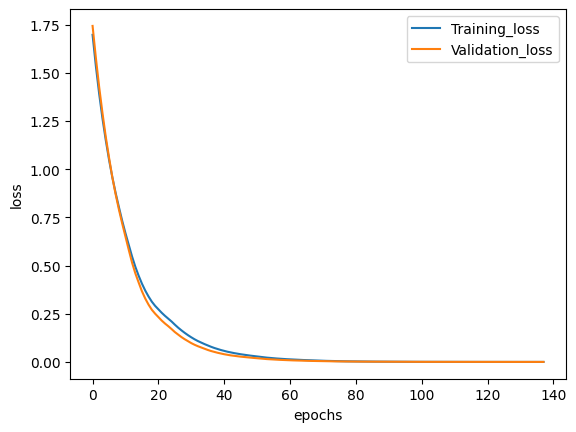

In [15]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Training_loss')
plt.plot(history.history['val_loss'], label='Validation_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

# Model check on Test data

In [16]:
test_loss, test_accuracy = model.evaluate(test_inputs, test_targets)

1/1 [==============================] - 0s 147ms/step - loss: 9.3038e-05 - root_mean_squared_error: 0.0096


In [17]:
print('\nTest loss: {0:.4f}. Test accuracy: {1:.4f} rmse'.format(test_loss, test_accuracy))


Test loss: 0.0001. Test accuracy: 0.0096 rmse


In [18]:
prediction = model.predict(test_inputs)
data_inputs = pd.DataFrame(test_inputs)
prediction = pd.DataFrame(prediction)
test_targets = pd.DataFrame(test_targets)
pred_accu = (prediction/test_targets)*100
pred_accu_avg = pred_accu.sum()/pred_accu.shape[0]

result = pd.concat([test_targets, prediction, pred_accu], axis = 1, ignore_index=True)
result.columns = ['Target-St(%)', 'Prediction-St(%)','prediction-accuracy(%)']
result

1/1 [==============================] - 0s 86ms/step


,Target-St(%),Prediction-St(%),prediction-accuracy(%)
0,0.971389,0.968164,99.667972
1,0.984452,0.985782,100.135084
2,0.976922,0.956500,97.909547
3,0.970551,0.960861,99.001559
4,0.946679,0.948820,100.226197
5,0.971013,0.968164,99.706608
6,0.990679,0.996470,100.584632
7,0.997296,0.993109,99.580183
8,0.950887,0.973677,102.396693
9,0.991350,0.995745,100.443336


In [24]:
uncertainty_model = abs(pred_accu_avg-100) 
print("Uncertainty of the ANN model:", np.round(uncertainty_model[0],2), '[%]')
print("Average test prediction precision", np.round(100 - uncertainty_model[0],2), '[%]')

Uncertainty of the ANN model: 0.08 [%]
Average test prediction precision 99.92 [%]


# ANN Model Deployment

ANN model deployment for micro DSC error prediction

In [20]:
import keras
model.save('micro_dsc_dl.h5')